Data Preprocessing

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the dataset
df = pd.read_csv('jira_priority_cleaned.csv', encoding='ISO-8859-1')

# Select relevant columns
df = df[['Summary', 'Priority']]

# Encode the 'Priority' column as the target variable
label_encoder = LabelEncoder()
df['Priority_encoded'] = label_encoder.fit_transform(df['Priority'])

# Text vectorization using TF-IDF
tfidf = TfidfVectorizer(max_features=500)  # Limit to top 500 features
X = tfidf.fit_transform(df['Summary']).toarray()

# Target variable
y = df['Priority_encoded']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



RNN-LSTM

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Load GloVe embeddings
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_embeddings = load_glove_embeddings('glove.6B.100d.txt')

# Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Summary'])
sequences = tokenizer.texts_to_sequences(df['Summary'])
word_index = tokenizer.word_index

X = pad_sequences(sequences, maxlen=100)
y = df['Priority_encoded']

# Prepare embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert target to categorical for multi-class classification
y_train_categorical = to_categorical(y_train, num_classes=4)
y_test_categorical = to_categorical(y_test, num_classes=4)

# Build the improved RNN-LSTM model
model = Sequential()
model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=100, trainable=False))
model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(32, activation='relu')))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))  # 4 classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_categorical, epochs=30, batch_size=32, validation_data=(X_test, y_test_categorical), verbose=1)

# Evaluate the model on test data
rnn_lstm_results = model.evaluate(X_test, y_test_categorical)
print('Improved RNN-LSTM Results:', rnn_lstm_results)



c:\Users\91882\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 0.4757 - loss: 1.2896 - val_accuracy: 0.6204 - val_loss: 1.1891
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.6629 - loss: 1.0964 - val_accuracy: 0.6204 - val_loss: 1.1265
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.6921 - loss: 1.0354 - val_accuracy: 0.6204 - val_loss: 1.1163
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.6661 - loss: 1.0310 - val_accuracy: 0.6204 - val_loss: 1.1084
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.6818 - loss: 1.0053 - val_accuracy: 0.6204 - val_loss: 1.1138
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.6597 - loss: 1.0020 - val_accuracy: 0.6204 - val_loss: 1.1160
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.6533 - loss: 1.0306 - val_accuracy: 0.6204 - val_loss: 1.1114
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.6775 - loss: 0.9831 - val_accuracy: 0.6204 -

Prediction Function

In [3]:
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Preprocess the description to obtain a vector
def preprocess_description(description):
    tokens = word_tokenize(description)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    vector = np.zeros(100)
    for i, token in enumerate(tokens[:100]):
        vector[i] = hash(token) % 100  # Simple hashing for demonstration
    return vector

# Define the mapping of numeric predictions to priority labels
priority_mapping = {
    0: 'Blocker',
    1: 'Critical',
    2: 'Major',
    3: 'Minor'
}
# Example usage
user_input_description = "Application crashes when submitting the form with special characters."
issue_data = preprocess_description(user_input_description)

# Reshape the data to match model's expected input
issue_data_rnn = np.expand_dims(issue_data, axis=0)  # Shape becomes (1, 100)

# RNN-LSTM prediction
rnn_lstm_pred = model.predict(issue_data_rnn)
rnn_lstm_pred_label = label_encoder.inverse_transform([np.argmax(rnn_lstm_pred)])

# Print predictions
print(f"RNN-LSTM predicted priority: {rnn_lstm_pred_label[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
RNN-LSTM predicted priority: Major


Pareto Chart : > Shows the frequency of each priority and the cumulative percentage. 
               > The horizontal line at 80% helps to identify the most significant priorities according to the Pareto Principle.

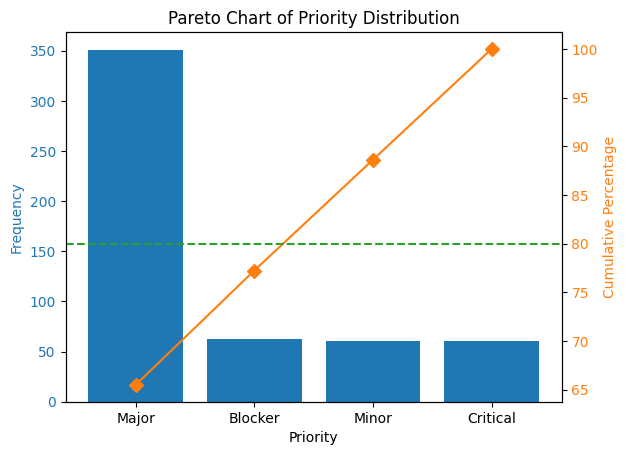

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv('jira_priority_cleaned.csv', encoding='ISO-8859-1')

# Count the occurrences of each priority
priority_counts = df['Priority'].value_counts()

# Sort the priorities by count in descending order
priority_counts = priority_counts.sort_values(ascending=False)

# Calculate the cumulative percentage
cumulative_percentage = priority_counts.cumsum() / priority_counts.sum() * 100

# Create the Pareto chart
fig, ax1 = plt.subplots()

# Bar plot for the priority counts
ax1.bar(priority_counts.index, priority_counts, color='C0')
ax1.set_xlabel('Priority')
ax1.set_ylabel('Frequency', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

# Line plot for the cumulative percentage
ax2 = ax1.twinx()
ax2.plot(priority_counts.index, cumulative_percentage, color='C1', marker='D', ms=7)
ax2.set_ylabel('Cumulative Percentage', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')

# Add a horizontal line at 80%
ax2.axhline(80, color='C2', linestyle='--')

plt.title('Pareto Chart of Priority Distribution')
plt.show()
